In [1]:
import pystare as ps

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import geopandas

import os
import sys
from io import BytesIO

%matplotlib inline
# %matplotlib notebook

In [2]:
def divert_stderr():
    sys.stderr = open('stderr.out','w')  
    return

def restore_stderr():
    sys.stderr.close()
    with open('stderr.out') as f:
        count = sum(1 for _ in f)
    if count > 0:
        print(count, 'warnings or errors encountered while stderr diverted. See stderr.out.')
    sys.stderr = sys.__stderr__
    return

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

# Some helper functions for plotting & printing.

class figax_container(object):
    def __init__(self,figax,plot_options=None):
        self.fig = figax[0]
        self.ax  = figax[1]
        self.plot_options = plot_options
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options=None
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,lw=1
        ,dbg=False
        ):


    
    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        
        if dbg:
            print('lons: ',lons)
            print('lats: ',lats)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        # print('plot type triang: ',type(siv_triang))

    if plot_options is None:
        if spatial_index_values is not None:
            plot_options = {
                'projection':ccrs.PlateCarree(
                    central_longitude=((0.5*((numpy.amin(180+lons)+numpy.amax(180+lons)) % 360.0))-180)
                                              # ,central_latitude=0.5*(numpy.amin(lats)+numpy.amax(lats))
                                                )
            ,'transform':ccrs.Geodetic()}
            print('hp-po central_longitude: '
              ,((0.5*((numpy.amin(180+lons)+numpy.amax(180+lons)) % 360.0))-180)
             )
        else:
            plot_options = {'projection':ccrs.PlateCarree()
                           ,'transform':ccrs.Geodetic()}

        
    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options),plot_options=plot_options)
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax  
        
    if spatial_index_values is not None: 
        divert_stderr()
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'],lw=lw)
        restore_stderr()
    
    if show:
        plt.show()
        
    if dbg:
        return figax,lons,lat,intmat
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

hp-po central_longitude:  -155.55818051066547
hp-po central_longitude:  -156.30110673056208
hp-po central_longitude:  -157.0019868813606
hp-po central_longitude:  -158.10011808912424
hp-po central_longitude:  -159.64936778537563


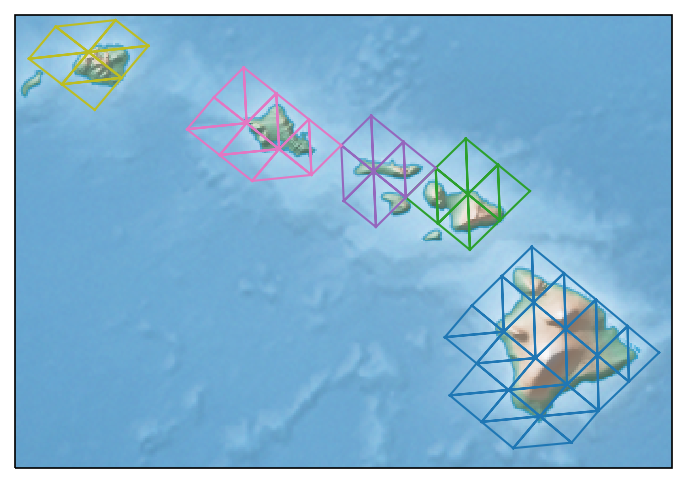

In [3]:
# Make covers from shapely polygons using convex hulls

cover_resolution = 8

figax = hello_plot(set_coastlines=False,set_global=False,show=False)  
        
lines = list(cf.COASTLINE.geometries())[107:112]

multiline = shapely.geometry.MultiLineString(lines)
# figax.ax.add_geometries(multiline,cf.COASTLINE.crs,color='c',alpha=0.5)
# figax.ax.set_extent(numpy.array(multiline.bounds)[[0,2,1,3]])

lons,lats = lonlat_from_coords(list(lines[0].coords))

covers = []
for k in range(len(lines)):
    # lons,lats = lonlat_from_coords(list(lines[k].coords))
    covers = covers + [ps.from_polygon(shapely.geometry.Polygon(lines[k]),resolution=cover_resolution
                                       ,nonconvex=False)]
    
    # Default Cartopy background imagery
    # figax.ax.stock_img()

    # For an example of how to add imagery for background_img, see extras/05-FetchNaturalEarth-1.
    # figax.ax.background_img(name='ne_shaded') # Identical to stock_img.
    # figax.ax.background_img(name='ne1_50m_sr_w')
    # figax.ax.background_img(name='ne1_10m_sr_w_dr')
    # figax.ax.background_img(name='hypso_50m_sr_w')
    figax.ax.background_img(name='hypso_10m_sr_w_ob_dr')
    
    # figax = hello_plot(ps.expand_intervals(covers[k],8),figax,show=False)
    figax = hello_plot(covers[k],figax,show=False)
                      
figax.ax.set_extent(numpy.array([-160.3, 18.5, -154.5, 22.5])[[0,2,1,3]])

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.

In [4]:
covers[0][0:1]

array([1171498853069750280])

In [6]:
###########################################################################
# https://stackoverflow.com/questions/41596386/tripcolor-using-rgb-values-for-each-vertex
#
def colors_to_cmap(colors):
    '''
    colors_to_cmap(nx3_or_nx4_rgba_array) yields a matplotlib colormap object that, when
    that will reproduce the colors in the given array when passed a list of n evenly
    spaced numbers between 0 and 1 (inclusive), where n is the length of the argument.

    Example:
      cmap = colors_to_cmap(colors)
      zs = numpy.asarray(range(len(colors)), dtype=numpy.float) / (len(colors)-1)
      # cmap(zs) should reproduce colors; cmap[zs[i]] == colors[i]
    '''
    colors = numpy.asarray(colors)
    if colors.shape[1] == 3:
        colors = numpy.hstack((colors, numpy.ones((len(colors),1))))
    steps = (0.5 + numpy.asarray(range(len(colors)-1), dtype=numpy.float))/(len(colors) - 1)
    return mpl.colors.LinearSegmentedColormap(
        'auto_cmap',
        {clrname: ([(0, col[0], col[0])] + 
                   [(step, c0, c1) for (step,c0,c1) in zip(steps, col[:-1], col[1:])] + 
                   [(1, col[-1], col[-1])])
         for (clridx,clrname) in enumerate(['red', 'green', 'blue', 'alpha'])
         for col in [colors[:,clridx]]},
        N=len(colors))

# https://stackoverflow.com/questions/765736/using-pil-to-make-all-white-pixels-transparent

def make_transparent(img):
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    return img


hp-po central_longitude:  -155.68385939588558
hp-po central_longitude:  -155.92168892455896


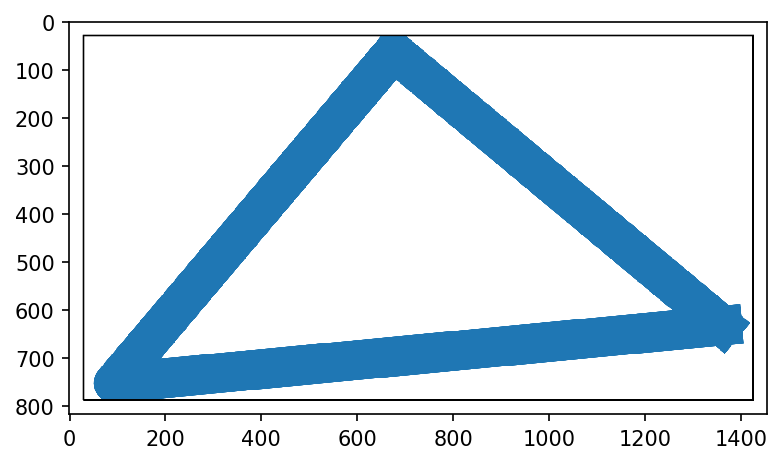

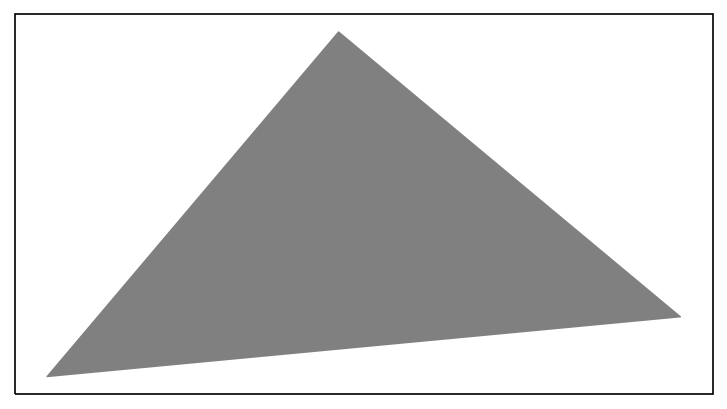

In [8]:

file = BytesIO()

def make_img(cover):
    figax = hello_plot(set_coastlines=False,set_global=False,show=False
                        ,plot_options = {'projection':ccrs.PlateCarree()
                                        ,'transform':ccrs.Geodetic()})
    trixel = covers[0][0:1]
    figax = hello_plot(cover,figax,show=False,lw=20)

    xlim = figax.ax.get_xlim()
    ylim = figax.ax.get_ylim()
    # print('x: ',xlim)
    # print('y: ',ylim)

    if False:
        plt.show()
    else:
        plt.close(figax.fig)
        figax.fig.savefig(file, dpi=300, bbox_inches='tight', transparent=True)
        file.name='test.png'
        file.seek(0)

        img = mpl.image.imread(file)
        # plt.imshow(img)
    return img,xlim+ylim

img0,ext0 = make_img(covers[0][0:1])
img1,ext1 = make_img(covers[0][1:2])

plt.imshow(img0)
plt.imshow(img1)
plt.show()

figax = hello_plot(set_coastlines=False,set_global=False,show=False)
trixel = covers[0][0:1]
lli = ps.triangulate_indices(trixel)
triang = tri.Triangulation(lli[0],lli[1],lli[2])

cd_plt = numpy.array(
    [[
    0.5,0.5,0.5
    ]]
)
cd_cmp = colors_to_cmap(cd_plt)
zs = numpy.asarray(range(3),dtype=numpy.float)/2.0
tripcolor_1_alpha = 1

figax.ax.tripcolor(triang,zs,cmap=cd_cmp,edgecolors='k',lw=0,shading='gouraud',alpha=tripcolor_1_alpha)
plt.show()


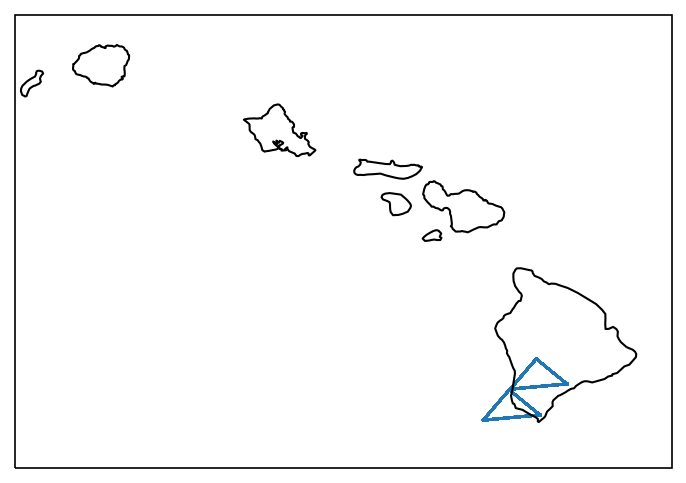

In [9]:
figax = hello_plot(set_coastlines=True,set_global=False,show=False)
figax.ax.set_extent(numpy.array([-160.3, 18.5, -154.5, 22.5])[[0,2,1,3]])
plt.imshow(img0,extent=ext0)
plt.imshow(img1,extent=ext1)
plt.show()


In [10]:
print(cartopy.config['data_dir'])
print(os.path.join(cartopy.__path__[0], "data", "raster", "natural_earth"))
!ls /Users/mrilee/opt/anaconda3/envs/develop/lib/python3.7/site-packages/cartopy/data/raster/natural_earth

/Users/mrilee/.local/share/cartopy
/Users/mrilee/opt/anaconda3/envs/develop/lib/python3.7/site-packages/cartopy/data/raster/natural_earth
50-natural-earth-1-downsampled.png images.json
HYP_50M_SR_W.tif                   images.json.sav
HYP_HR_SR_OB_DR.tif                images.json.sav-1
NE1_50M_SR_W.tif                   images.json.sav-2
NE1_HR_LC_SR_W_DR.tif              notes.org


In [11]:
fname = '/Users/mrilee/opt/anaconda3/envs/develop/lib/python3.7/site-packages/cartopy/data/raster/natural_earth/NE1_HR_LC_SR_W_DR.tif'
print('fname: ',fname)

fname:  /Users/mrilee/opt/anaconda3/envs/develop/lib/python3.7/site-packages/cartopy/data/raster/natural_earth/NE1_HR_LC_SR_W_DR.tif


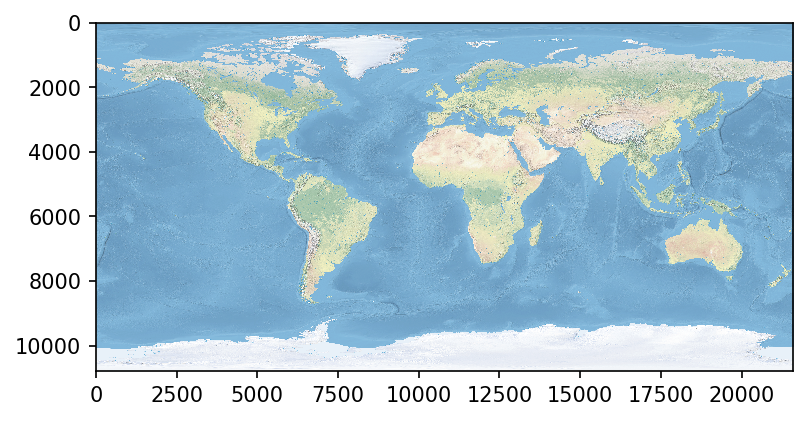

In [12]:
img10m = mpl.image.imread(fname)
plt.imshow(img10m)
plt.show()

In [13]:
img10m.shape

(10800, 21600, 3)

In [14]:
def to_ipos(ivar,shape):
    iy = ivar[0]
    ix = ivar[1]
    ic = ivar[2]
    return ic + shape[2] * ( ix + shape[1] * iy )

def to_iyxc(ipos,shape):
    ic = ipos % shape[2]
    ix = int((ipos-ic)/shape[2]) % shape[1]
    iy = int((((ipos-ic)/shape[2])-ix)/shape[1])
    return iy,ix,ic

In [15]:
delta = 1/60.0 # 10m
nlon = 21600; nlat = 10800
nlon0 = 1200; nlat0 = 4000
nlon1 = nlon0+150; nlat1 = nlat0+125

lats = numpy.zeros([nlat1-nlat0])
lons = numpy.zeros([nlon1-nlon0])

# ilat, ilon, icolor

sivs10m = numpy.zeros([lats.size,lons.size],dtype=numpy.int64)
idptr10 = numpy.zeros([lats.size,lons.size],dtype=numpy.int64)
idptr10_yxc_flat = numpy.zeros([lats.size*lons.size*3],dtype=numpy.int64)

print('sivs10m.shape: ',sivs10m.shape)

def mk_lat(ilat,delta):
    return 90.0-(ilat+0.5)*delta
def mk_lon(ilon,delta):
    return -180+(ilon+0.5)*delta

iposk = 0
for ilat in range(nlat0,nlat1,1):
    lat = mk_lat(ilat,delta)
    for ilon in range(nlon0,nlon1,1):
        lon = mk_lon(ilon,delta)
        # print(ilat-nlat0,ilon-nlon0)
        sivs10m[ilat-nlat0,ilon-nlon0]=ps.from_latlon([lat],[lon],13)
        # print('lon,lat',ilat,ilon,lon,lat,sivs10m[ilat,ilon])
        idptr10[ilat-nlat0,ilon-nlon0] = ilat*nlon + ilon
        ipos = to_ipos((ilat,ilon,0),[nlat,nlon,3])
        for icolor in range(3):
            idptr10_yxc_flat[iposk+icolor] = ipos+icolor
        iposk = iposk+3
print('lats: ',mk_lat(nlat0,delta),mk_lat(nlat1,delta))
print('lons: ',mk_lon(nlon0,delta),mk_lon(nlon1,delta))
print('idptr10_yxc_flat shape: ',idptr10_yxc_flat)
sivs10m_flat = sivs10m.flatten()
idptr10_flat = idptr10.flatten()



sivs10m.shape:  (125, 150)
lats:  23.325000000000003 21.241666666666674
lons:  -159.99166666666667 -157.49166666666667
idptr10_yxc_flat shape:  [259203600 259203601 259203602 ... 267239247 267239248 267239249]


In [16]:
def get_tgt_extent(nlon0,nlat0,nlon1,nlat1,delta):
    lons = numpy.array([mk_lon(nlon0,delta),mk_lon(nlon1,delta)])
    lats = numpy.array([mk_lat(nlat0,delta),mk_lat(nlat1,delta)])
    return (numpy.amin(lons),numpy.amax(lons),numpy.amin(lats),numpy.amax(lats))

tgt_extent = get_tgt_extent(nlon0,nlat0,nlon1,nlat1,delta)

In [17]:
tgt_extent

(-159.99166666666667,
 -157.49166666666667,
 21.241666666666674,
 23.325000000000003)

In [18]:
ps.from_latlon([-179.992],[89.99],8) & 31

array([8])

hp-po central_longitude:  -158.75348667811778


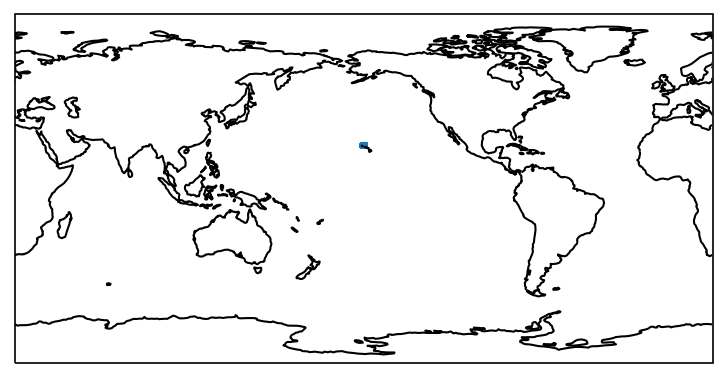

In [19]:
figax = hello_plot(sivs10m.flatten(),set_global=True,show=False)
# figax.ax.set_extent([-180,-160,73-10,74+10])
# figax.ax.set_xlim(0,10)
# figax.ax.set_ylim(72,74)
plt.show()

lons:  [-159.99768668 -159.99667941 -159.98850218]
lats:  [23.33097748 23.31562077 23.32393642]
hp-po central_longitude:  -159.9930944297397


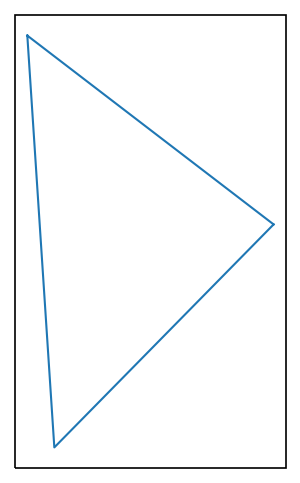

In [20]:
# figax = hello_plot(sivs10m.flatten(),set_global=True)
fg_pad = 0.01 # degrees
for i in sivs10m.flatten()[0:1]:
    figax,lons_fg,lats_fg,intmat_fg \
        = hello_plot([i],dbg=True,show=False)
#        = hello_plot([i],dbg=True,show=False,set_global=False
#                     ,plot_options={'projection':ccrs.PlateCarree(central_longitude=-180)
#                                    ,'transform':ccrs.Geodetic()}
#                    )
    # figax.ax.set_xlim(numpy.amin(lons_fg)-fg_pad,numpy.amax(lons_fg)+fg_pad)
    # figax.ax.set_ylim(numpy.amin(lats_fg)-fg_pad,numpy.amax(lats_fg)+fg_pad)
    plt.show()
        

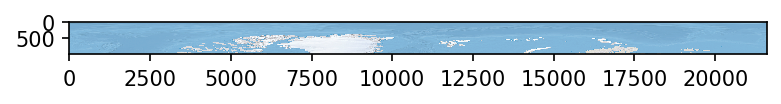

In [21]:
img10m = mpl.image.imread(fname)
plt.imshow(img10m[0:1000,0:21600,:])
plt.show()

In [22]:
iflat_idx    = numpy.arange(img10m.size)
imgtest_flat = (255*iflat_idx/(1.0*img10m.size)).astype(numpy.uint8)
imgtest      = numpy.reshape(imgtest_flat,img10m.shape)

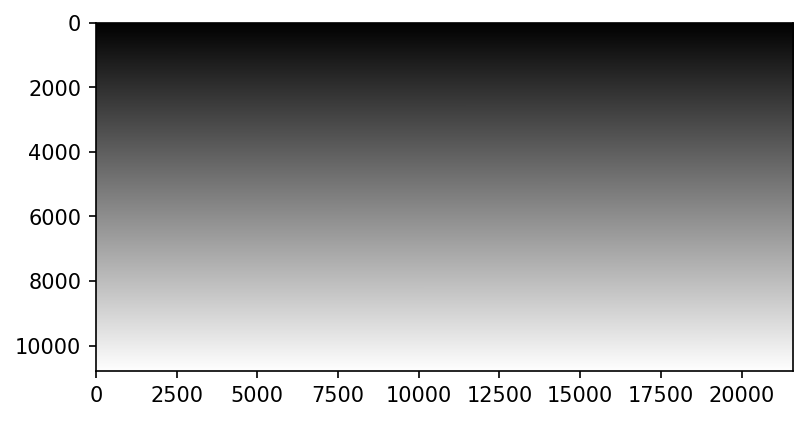

In [23]:
plt.imshow(imgtest)
plt.show()

In [24]:
ipos = 0
iflat_idx_testcalc    = numpy.arange(img10m.size)
for ilat in range(nlat):
    for ilon in range(nlon):
        for icolor in range(3):
            iflat_idx_testcalc[ipos] = icolor + 3*( ilon + nlon * ilat)
            ipos = ipos + 1

In [25]:
iflat_idx_testcalc[1000001]

1000001

In [26]:
test_shape = img10m.shape
ivar=(10,10,1); print('round trip test: ',ivar,to_ipos(ivar,test_shape),ivar == to_iyxc(to_ipos(ivar,test_shape),test_shape))
ivar=(0,10,2); print('round trip test: ',ivar,to_ipos(ivar,test_shape),ivar == to_iyxc(to_ipos(ivar,test_shape),test_shape))
ivar=(100,1000,0); print('round trip test: ',ivar,to_ipos(ivar,test_shape),ivar == to_iyxc(to_ipos(ivar,test_shape),test_shape))

round trip test:  (10, 10, 1) 648031 True
round trip test:  (0, 10, 2) 32 True
round trip test:  (100, 1000, 0) 6483000 True


In [27]:
img10m_flat = img10m.flatten()
img_tgt_flat = numpy.ones(img10m.shape,dtype=img10m.dtype).flatten()

# idptr10_flat = numpy.arange(nlon*nlat,dtype=numpy.int64)

print('shape img10m_flat:  ',img10m_flat.shape)
print('shape img_tgt_flat: ',img_tgt_flat.shape)
print('shape idptr10_flat: ',idptr10_flat.shape)

shape img10m_flat:   (699840000,)
shape img_tgt_flat:  (699840000,)
shape idptr10_flat:  (18750,)


In [28]:
print('idx yxc range: ',numpy.amin(idptr10_yxc_flat),numpy.amax(idptr10_yxc_flat))

idx yxc range:  259203600 267239249


In [29]:
# img_tgt_flat[:] = img10m_flat[:]
img_tgt_flat[idptr10_yxc_flat] = img10m_flat[idptr10_yxc_flat]
print('img tgt range: ',numpy.amin(img_tgt_flat),numpy.amax(img_tgt_flat))

img tgt range:  1 236


In [30]:
img_tgt = numpy.reshape(img_tgt_flat,img10m.shape)
print('img tgt shape: ',img_tgt.shape)
print('img tgt range: ',numpy.amin(img_tgt),numpy.amax(img_tgt))
print('img tgt type:  ',img_tgt.dtype)

img tgt shape:  (10800, 21600, 3)
img tgt range:  1 236
img tgt type:   uint8


In [31]:
img_tgt_crop = numpy.zeros([nlat1-nlat0,nlon1-nlon0,3],dtype=numpy.uint8)
img10m__crop = numpy.zeros([nlat1-nlat0,nlon1-nlon0,3],dtype=numpy.uint8)

img_tgt_crop[:,:,:] = img_tgt[nlat0:nlat1,nlon0:nlon1,:]
img10m__crop[:,:,:] = img10m[nlat0:nlat1,nlon0:nlon1,:]
print('cropped shapes: ',img_tgt_crop.shape,img10m__crop.shape)
print('src minmax:     ',numpy.amin(img10m__crop),numpy.amax(img10m__crop))
print('tgt minmax:     ',numpy.amin(img_tgt_crop),numpy.amax(img_tgt_crop))

cropped shapes:  (125, 150, 3) (125, 150, 3)
src minmax:      66 236
tgt minmax:      66 236


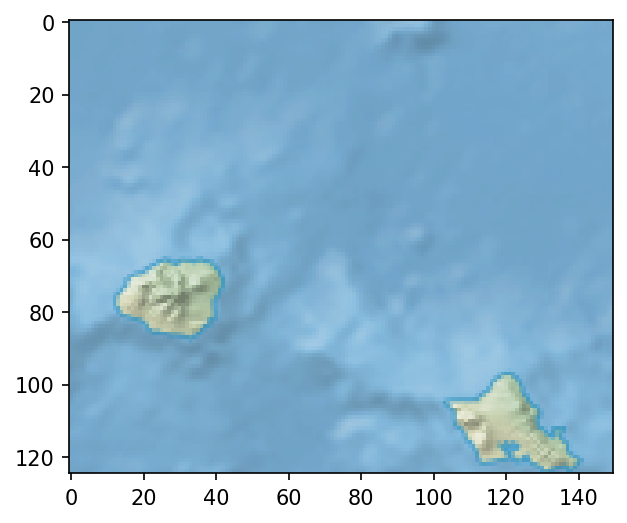

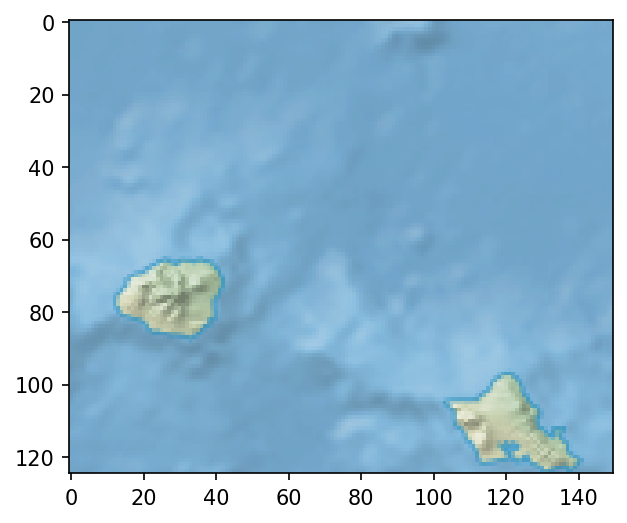

In [32]:
plt.imshow(img_tgt_crop)
plt.show()
plt.imshow(img10m__crop)
plt.show()

hp-po central_longitude:  -160.17642520126714


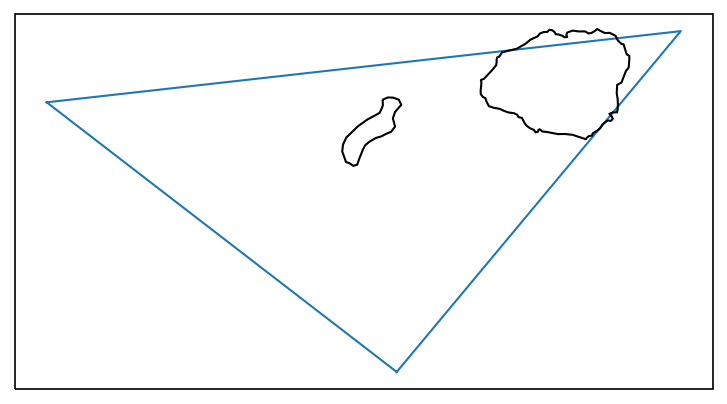

In [33]:
siv_target = ps.from_latlon([22.0],[-159.993],6)
figax = hello_plot(siv_target,show=False,set_global=False)
plt.show()

In [34]:
siv_target_idx = ps.intersects(siv_target,sivs10m.flatten(),1) # Binary search and sort
siv_target_idx_default = ps.intersects(siv_target,sivs10m.flatten(),0) # Spatial range

In [35]:
siv_target_idx

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [36]:
siv_target_img_flat = 255*numpy.ones(sivs10m.shape+(3,),dtype=numpy.uint8).flatten()

In [37]:
siv_target_idx.shape,siv_target_img_flat.shape

((18750,), (56250,))

In [38]:
img_tgt_crop_flat = img_tgt_crop.flatten()

In [39]:
img_tgt_crop_flat.dtype

dtype('uint8')

In [40]:
k = 0
for i in range(siv_target_idx.size):
    if siv_target_idx[i] != 0:
        for ic in range(3):
            siv_target_img_flat[ic+3*i] = img_tgt_crop_flat[ic+3*i]
            k=k+1
print('k replaced: ',k)

k replaced:  4506


In [41]:
siv_target_img_flat.shape,siv_target_idx.size*3

((56250,), 56250)

In [42]:
siv_target_img = numpy.reshape(siv_target_img_flat,img_tgt_crop.shape)

In [43]:
# limits (-161,-157.5,21.24,24)
tgt_extent

(-159.99166666666667,
 -157.49166666666667,
 21.241666666666674,
 23.325000000000003)

hp-po central_longitude:  -160.17642520126714


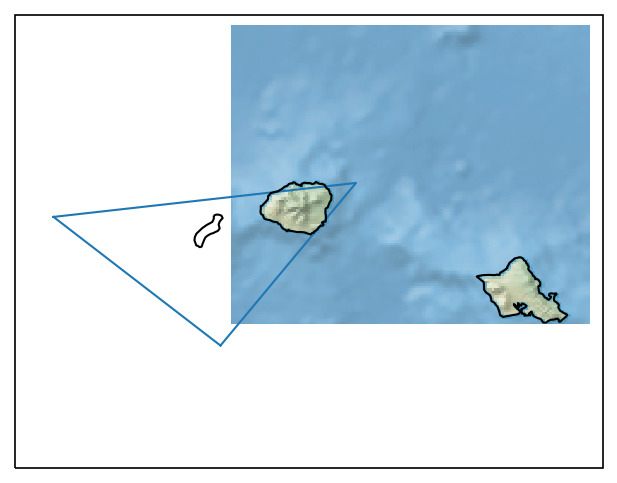

hp-po central_longitude:  -160.17642520126714


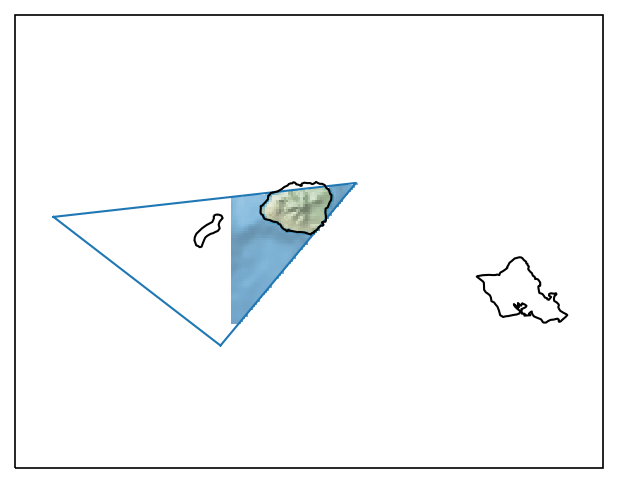

In [44]:
figax = hello_plot(show=False,set_global=False)
# figax.ax.imshow(img_tgt_crop,extent=tgt_extent,tranform=figax.plot_options['projection'])
# figax.ax.imshow(img_tgt_crop,extent=tgt_extent)
figax.ax.set_extent((-161.5,-157.4,20.24,23.4))
figax = hello_plot(siv_target,figax=figax,show=False)
figax.ax.imshow(img_tgt_crop,extent=tgt_extent)
plt.show()

figax = hello_plot(show=False,set_global=False)
figax.ax.set_extent((-161.5,-157.4,20.24,23.4))
figax = hello_plot(siv_target,figax=figax,show=False)
# figax.ax.set_extent(tgt_extent)
figax.ax.imshow(siv_target_img,extent=tgt_extent)
plt.show()

In [45]:

siv_target_img_default_flat = 255*numpy.ones(sivs10m.shape+(3,),dtype=numpy.uint8).flatten()
k = 0
for i in range(siv_target_idx.size):
    if siv_target_idx_default[i] != 0:
        for ic in range(3):
            siv_target_img_default_flat[ic+3*i] = img_tgt_crop_flat[ic+3*i]
            k=k+1
print('k replaced: ',k)
siv_target_img_default = numpy.reshape(siv_target_img_default_flat,img_tgt_crop.shape)


k replaced:  2697


hp-po central_longitude:  -160.17642520126714


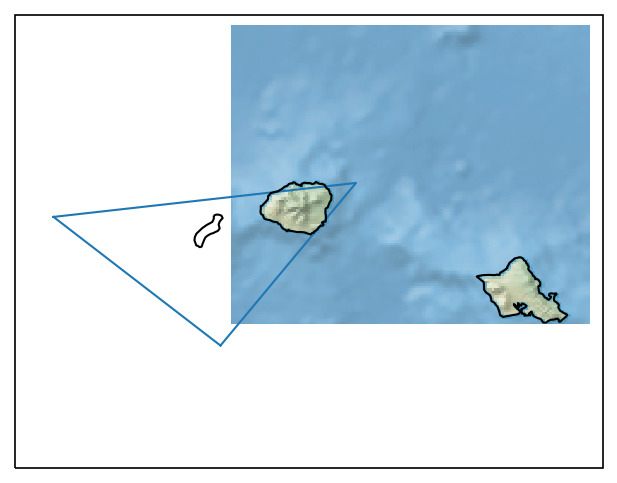

hp-po central_longitude:  -160.17642520126714


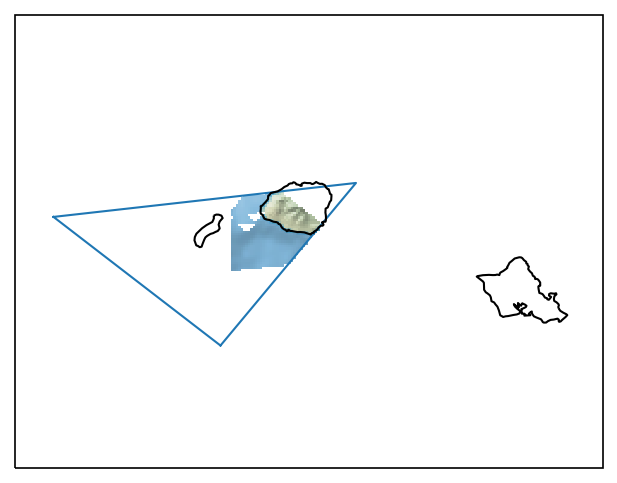

In [46]:
figax = hello_plot(show=False,set_global=False)
# figax.ax.imshow(img_tgt_crop,extent=tgt_extent,tranform=figax.plot_options['projection'])
# figax.ax.imshow(img_tgt_crop,extent=tgt_extent)
figax.ax.set_extent((-161.5,-157.4,20.24,23.4))
figax = hello_plot(siv_target,figax=figax,show=False)
figax.ax.imshow(img_tgt_crop,extent=tgt_extent)
plt.show()

figax = hello_plot(show=False,set_global=False)
figax.ax.set_extent((-161.5,-157.4,20.24,23.4))
figax = hello_plot(siv_target,figax=figax,show=False)
# figax.ax.set_extent(tgt_extent)
figax.ax.imshow(siv_target_img_default,extent=tgt_extent)
plt.show()